# CROP-seq KO150 - Interpret KO-crosspredcition-classifier results
- goal: provide biological meaning and functional intepretation to the established KO-phenotype-relationships (edges in the similarity graph)
- input: clf analysis results
- output: lists of overlapping DEGs of KOs and enrichment analysis of the edge-pair profiles

In [1]:
cd ../

/home/sreichl/projects/bmdm-stim


In [2]:
# libraries
# general
import os
import pandas as pd
import numpy as np

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# enrichment analysis
import gseapy as gp

import importlib

In [5]:
# import util functions
import sys
sys.path.insert(1, os.path.join('src'))

import utils_GSEApy

In [ ]:
# for relaoding a module
# importlib.reload(utils_GSEApy)

In [4]:
# configs

# cond = 'untreated'
# cond = 'LO28-6h'
# cond = 'LO28-24h'
cond='all'


dir_data = os.path.join('results','KO150')
dir_results = os.path.join(dir_data,'KO_classifier', cond)

# classifier flag
clf_label = 'LR'
# clf_label = 'RF'

# approach flag (counting or probabilities)
conn_label = 'prob'
# conn_label = 'count'

cut_off = 0.1


# enrichment configs
databases = ["BioPlanet_2019", 
             "KEGG_2019_Mouse", 
             "WikiPathways_2019_Mouse",
             "GO_Biological_Process_2021"]

# more stringent adj.p-value cut-off
# databases_strict=["BioPlanet_2019",
#            "GO_Biological_Process_2021"]
databases_strict=[]

adj_pvalue=0.05
adj_pvalue_strict=0.01

## Load & prepare data

In [7]:
# Load adjacency matrix
conn = pd.read_csv(os.path.join(dir_results, "KO150_clf{}_conn{}Norm.csv".format(clf_label,conn_label)), index_col=0)

# remove " KO" from dimensions
conn.columns = conn.columns.str.replace(' KO','')
conn.index = conn.index.str.replace(' KO','')

# apply cut_off in similarity (ie pruning)
conn[conn<cut_off] = 0

print(conn.shape)
conn.head()

(58, 58)


,LO28-24h+Chd4,LO28-24h+Ep400,LO28-24h+Ifnar1,LO28-24h+Ikzf1,LO28-24h+Irf9,LO28-24h+Jak1,LO28-24h+Myd88,LO28-24h+Sfpq,LO28-24h+Smc1a,LO28-24h+Spi1,...,untreated+Jak1,untreated+Med14,untreated+Runx1,untreated+Sf3b1,untreated+Sfpq,untreated+Smc1a,untreated+Spi1,untreated+Stat2,untreated+Tyk2,untreated+Yeats2
LO28-24h+Chd4,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LO28-24h+Ep400,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LO28-24h+Ifnar1,0.0,0.0,0.00000,0.0,0.460557,0.197412,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LO28-24h+Ikzf1,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LO28-24h+Irf9,0.0,0.0,0.38594,0.0,0.000000,0.164542,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# make symmetric to get similarity connectivity matrix
conn_sim = pd.DataFrame()
for ct1 in conn.index:
    for ct2 in conn.columns:
        conn_sim.loc[ct1, ct2] = (
            ((conn.loc[ct1, ct2] + conn.loc[ct2, ct1])/2)
        )
conn_sim.head()

,LO28-24h+Chd4,LO28-24h+Ep400,LO28-24h+Ifnar1,LO28-24h+Ikzf1,LO28-24h+Irf9,LO28-24h+Jak1,LO28-24h+Myd88,LO28-24h+Sfpq,LO28-24h+Smc1a,LO28-24h+Spi1,...,untreated+Jak1,untreated+Med14,untreated+Runx1,untreated+Sf3b1,untreated+Sfpq,untreated+Smc1a,untreated+Spi1,untreated+Stat2,untreated+Tyk2,untreated+Yeats2
LO28-24h+Chd4,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LO28-24h+Ep400,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LO28-24h+Ifnar1,0.0,0.0,0.000000,0.0,0.423248,0.275551,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LO28-24h+Ikzf1,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.099824,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LO28-24h+Irf9,0.0,0.0,0.423248,0.0,0.000000,0.245157,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Determine DEA overlaps

In [9]:
if not os.path.exists(os.path.join(dir_results, 'interpretation')):
        os.mkdir(os.path.join(dir_results, 'interpretation'))

In [10]:
# identify pairs and sort by similarity value
conn_triu = conn_sim.where(np.triu(np.ones(conn_sim.shape)).astype(bool))

conn_triu = conn_triu.stack().reset_index()
conn_triu.columns = ['KO_1','KO_2','similarity']

conn_triu = conn_triu.loc[conn_triu['similarity']!=0,:]

conn_triu = conn_triu.sort_values(by='similarity', ascending=False)

print(conn_triu.shape)
conn_triu.head()

(73, 3)


,KO_1,KO_2,similarity
1457,LO28-6h+Yeats2,untreated+Yeats2,0.429483
117,LO28-24h+Ifnar1,LO28-24h+Irf9,0.423248
973,LO28-6h+Ifnar1,LO28-6h+Irf9,0.414679
1622,untreated+Ifnar1,untreated+Irf9,0.412218
1092,LO28-6h+Irf9,LO28-6h+Stat2,0.397695


In [11]:
if not os.path.exists(os.path.join(dir_results, 'interpretation','overlaps')):
        os.mkdir(os.path.join(dir_results, 'interpretation','overlaps'))

In [12]:
# load dea results, determine overlaps and generate aggregated tables with DEA results
stat_sig = 0.05
top_n = 250

# gene list dictionaries for enrichment analysis
gene_lists_stat = dict()
gene_lists_top = dict()

for index, row in conn_triu.iterrows():

    # load the DEA results
    DEA_1 = pd.read_csv(os.path.join(dir_data, 'DEA_condition_mixscape','KO150_DEA_RNA_{}_{}.csv'.format(row['KO_1'].split('+')[0],row['KO_1'].split('+')[1])), index_col=0)
    DEA_2 = pd.read_csv(os.path.join(dir_data, 'DEA_condition_mixscape','KO150_DEA_RNA_{}_{}.csv'.format(row['KO_2'].split('+')[0],row['KO_2'].split('+')[1])), index_col=0)

    # sort by raw p-value
    DEA_1 = DEA_1.sort_values(by='p_val')
    DEA_2 = DEA_2.sort_values(by='p_val')
    
    # determine intersecting genes per direction
    intersect_stat_up = set(DEA_1.index[(DEA_1['p_val_adj']<stat_sig)&(DEA_1['avg_log2FC']>0)]).intersection(set(DEA_2.index[(DEA_2['p_val_adj']<stat_sig)&(DEA_2['avg_log2FC']>0)]))
    intersect_stat_down = set(DEA_1.index[(DEA_1['p_val_adj']<stat_sig)&(DEA_1['avg_log2FC']<0)]).intersection(set(DEA_2.index[(DEA_2['p_val_adj']<stat_sig)&(DEA_2['avg_log2FC']<0)]))
    intersect_stat = intersect_stat_up.union(intersect_stat_down)
    
    intersect_top_up = set(DEA_1.index[(DEA_1['avg_log2FC']>0)][:top_n]).intersection(set(DEA_2.index[(DEA_2['avg_log2FC']>0)][:top_n]))
    intersect_top_down = set(DEA_1.index[(DEA_1['avg_log2FC']<0)][:top_n]).intersection(set(DEA_2.index[(DEA_2['avg_log2FC']<0)][:top_n]))
    intersect_top = intersect_top_up.union(intersect_top_down)

    # aggregate DEA results of intersecting genes
    df_stat = pd.concat([DEA_1.loc[intersect_stat,].add_prefix(row['KO_1']+'_'), DEA_2.loc[intersect_stat,].add_prefix(row['KO_2']+'_')], axis=1)
    df_top = pd.concat([DEA_1.loc[intersect_top,].add_prefix(row['KO_1']+'_'), DEA_2.loc[intersect_top,].add_prefix(row['KO_2']+'_')], axis=1)

    # save aggregation dataframes
    df_stat.to_csv(os.path.join(dir_results, 'interpretation','overlaps',"{}-{}_stat.csv".format(row['KO_1'],row['KO_2'])))
    df_top.to_csv(os.path.join(dir_results, 'interpretation','overlaps',"{}-{}_top{}.csv".format(row['KO_1'],row['KO_2'], top_n)))
    
    # log number of genes 
    conn_triu.loc[index,'stat_n'] = len(intersect_stat)
    conn_triu.loc[index,'top_n'] = len(df_top)
    
    # fill gene list dictionaries for enrichment analysis
    gene_lists_stat["{}-{}_{}".format(row['KO_1'],row['KO_2'], 'up')] = intersect_stat_up
    gene_lists_stat["{}-{}_{}".format(row['KO_1'],row['KO_2'], 'down')] = intersect_stat_down
    
    gene_lists_top["{}-{}_{}".format(row['KO_1'],row['KO_2'], 'up')] = intersect_top_up
    gene_lists_top["{}-{}_{}".format(row['KO_1'],row['KO_2'], 'down')] = intersect_top_down
    
conn_triu.to_csv(os.path.join(dir_results, 'interpretation',"KO150_clf{}_conn{}_cutoff{}_similarities.csv".format(clf_label,conn_label,cut_off)), index=False)

In [13]:
conn_triu.head()

,KO_1,KO_2,similarity,stat_n,top_n
1457,LO28-6h+Yeats2,untreated+Yeats2,0.429483,50.0,91.0
117,LO28-24h+Ifnar1,LO28-24h+Irf9,0.423248,79.0,228.0
973,LO28-6h+Ifnar1,LO28-6h+Irf9,0.414679,270.0,312.0
1622,untreated+Ifnar1,untreated+Irf9,0.412218,63.0,173.0
1092,LO28-6h+Irf9,LO28-6h+Stat2,0.397695,208.0,278.0


<AxesSubplot:xlabel='similarity'>

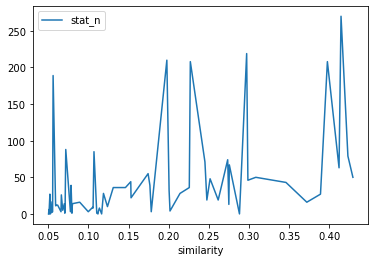

In [14]:
conn_triu.plot('similarity', 'stat_n')

<AxesSubplot:xlabel='similarity'>

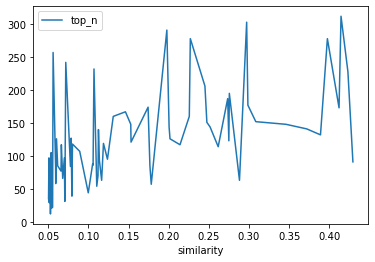

In [15]:
conn_triu.plot('similarity', 'top_n')

## Enrichment analysis on the determined overlaps

In [16]:
if not os.path.exists(os.path.join(dir_results, 'interpretation', 'enrichment_analysis')):
        os.mkdir(os.path.join(dir_results, 'interpretation', 'enrichment_analysis'))

In [17]:
# define background gene set based on unsupervised analysis performed cells selected by condition-wise mixscape analysis and then used for the DEA
SCT_counts = pd.read_csv(os.path.join(dir_data, 'unsupervised_mixscape','KO150_SCT_counts.csv'), index_col=0)
print(SCT_counts.shape)
SCT_counts.head()

# define list of background genes
background = SCT_counts.index
background = list(set(background))
background=[str(x).upper() for x in list(background)]
print(len(background))
background[:5]

(14845, 6187)
14845


['RTTN', 'A430033K04RIK', '5033406O09RIK', 'SNW1', 'FAM198B']

In [18]:
print(len(gene_lists_stat.keys()))    
print(len(gene_lists_top.keys()))

146
146


In [19]:
assert(gene_lists_top.keys()==gene_lists_stat.keys())

In [20]:
# convert gene IDs to symbols, and upper-case
for key in gene_lists_stat.keys():
    gene_lists_stat[key] = list(gene_lists_stat[key])
    gene_lists_stat[key] = [str(x).upper() for x in list(gene_lists_stat[key])]
    
    gene_lists_top[key] = list(gene_lists_top[key])
    gene_lists_top[key] = [str(x).upper() for x in list(gene_lists_top[key])]

In [126]:
util_GSEApy.do_enrichment_all(gene_lists=gene_lists_stat, 
                  background=background, 
                  databases=databases, 
                  databases_strict=databases_strict, 
                  adj_pvalue=adj_pvalue, 
                  adj_pvalue_strict=adj_pvalue_strict, 
                  dir_results=os.path.join(dir_results, 'interpretation', 'enrichment_analysis','stat'),
                  top_n = 3
                 )

/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

BioPlanet_2019


2021-11-25 15:04:30,133 Warning: No enrich terms using library CUSTOM46915442869952 when cutoff = 0.05
2021-11-25 15:04:45,059 Warning: No enrich terms using library CUSTOM46915442869952 when cutoff = 0.05
2021-11-25 15:04:45,802 Warning: No enrich terms using library CUSTOM46915442869952 when cutoff = 0.05
2021-11-25 15:04:50,323 Warning: No enrich terms using library CUSTOM46915442869952 when cutoff = 0.05
2021-11-25 15:04:50,572 Warning: No enrich terms using library CUSTOM46915442869952 when cutoff = 0.05
2021-11-25 15:05:09,705 Warning: No enrich terms using library CUSTOM46915442869952 when cutoff = 0.05
2021-11-25 15:05:11,123 Warning: No enrich terms using library CUSTOM46915442869952 when cutoff = 0.05
2021-11-25 15:05:11,583 Warning: No enrich terms using library CUSTOM46915442869952 when cutoff = 0.05
2021-11-25 15:05:24,222 Warning: No enrich terms using library CUSTOM46915442869952 when cutoff = 0.05
2021-11-25 15:05:24,422 Warning: No enrich terms using library CUSTOM4691

KEGG_2019_Mouse


2021-11-25 15:05:48,517 Warning: No enrich terms using library CUSTOM46915465242240 when cutoff = 0.05
2021-11-25 15:05:53,094 Warning: No enrich terms using library CUSTOM46915465242240 when cutoff = 0.05
2021-11-25 15:05:56,232 Warning: No enrich terms using library CUSTOM46915465242240 when cutoff = 0.05
2021-11-25 15:05:56,801 Warning: No enrich terms using library CUSTOM46915465242240 when cutoff = 0.05
2021-11-25 15:05:59,264 Warning: No enrich terms using library CUSTOM46915465242240 when cutoff = 0.05
2021-11-25 15:06:01,299 Warning: No enrich terms using library CUSTOM46915465242240 when cutoff = 0.05
2021-11-25 15:06:02,152 Warning: No enrich terms using library CUSTOM46915465242240 when cutoff = 0.05
2021-11-25 15:06:02,225 Warning: No enrich terms using library CUSTOM46915465242240 when cutoff = 0.05
2021-11-25 15:06:11,023 Warning: No enrich terms using library CUSTOM46915465242240 when cutoff = 0.05
2021-11-25 15:06:12,451 Warning: No enrich terms using library CUSTOM4691

WikiPathways_2019_Mouse


2021-11-25 15:06:34,940 Warning: No enrich terms using library CUSTOM46914644318528 when cutoff = 0.05
2021-11-25 15:06:39,010 Warning: No enrich terms using library CUSTOM46914644318528 when cutoff = 0.05
2021-11-25 15:06:47,124 Warning: No enrich terms using library CUSTOM46914644318528 when cutoff = 0.05
2021-11-25 15:06:48,995 Warning: No enrich terms using library CUSTOM46914644318528 when cutoff = 0.05
2021-11-25 15:06:55,239 Warning: No enrich terms using library CUSTOM46914644318528 when cutoff = 0.05
2021-11-25 15:06:56,246 Warning: No enrich terms using library CUSTOM46914644318528 when cutoff = 0.05
2021-11-25 15:06:56,577 Warning: No enrich terms using library CUSTOM46914644318528 when cutoff = 0.05


GO_Biological_Process_2021


2021-11-25 15:07:41,264 Warning: No enrich terms using library CUSTOM46914684554688 when cutoff = 0.05


BioPlanet_2019 452
KEGG_2019_Mouse 140
WikiPathways_2019_Mouse 81
GO_Biological_Process_2021 1850


In [127]:
util_GSEApy.do_enrichment_all(gene_lists=gene_lists_top, 
                  background=background, 
                  databases=databases, 
                  databases_strict=databases_strict, 
                  adj_pvalue=adj_pvalue, 
                  adj_pvalue_strict=adj_pvalue_strict, 
                  dir_results=os.path.join(dir_results, 'interpretation', 'enrichment_analysis','top'),
                  top_n = 3
                 )

/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

BioPlanet_2019


2021-11-25 15:14:09,485 Warning: No enrich terms using library CUSTOM46914681677888 when cutoff = 0.05
2021-11-25 15:14:11,836 Warning: No enrich terms using library CUSTOM46914681677888 when cutoff = 0.05
2021-11-25 15:14:14,128 Warning: No enrich terms using library CUSTOM46914681677888 when cutoff = 0.05
2021-11-25 15:14:18,726 Warning: No enrich terms using library CUSTOM46914681677888 when cutoff = 0.05
2021-11-25 15:14:22,812 Warning: No enrich terms using library CUSTOM46914681677888 when cutoff = 0.05
2021-11-25 15:14:31,701 Warning: No enrich terms using library CUSTOM46914681677888 when cutoff = 0.05
2021-11-25 15:14:40,787 Warning: No enrich terms using library CUSTOM46914681677888 when cutoff = 0.05
2021-11-25 15:14:47,650 Warning: No enrich terms using library CUSTOM46914681677888 when cutoff = 0.05
2021-11-25 15:15:01,242 Warning: No enrich terms using library CUSTOM46914681677888 when cutoff = 0.05
2021-11-25 15:15:24,020 Warning: No enrich terms using library CUSTOM4691

KEGG_2019_Mouse


2021-11-25 15:16:49,607 Warning: No enrich terms using library CUSTOM46915440417344 when cutoff = 0.05
2021-11-25 15:16:50,893 Warning: No enrich terms using library CUSTOM46915440417344 when cutoff = 0.05
2021-11-25 15:16:58,228 Warning: No enrich terms using library CUSTOM46915440417344 when cutoff = 0.05
2021-11-25 15:16:59,963 Warning: No enrich terms using library CUSTOM46915440417344 when cutoff = 0.05
2021-11-25 15:17:09,776 Warning: No enrich terms using library CUSTOM46915440417344 when cutoff = 0.05
2021-11-25 15:17:17,442 Warning: No enrich terms using library CUSTOM46915440417344 when cutoff = 0.05
2021-11-25 15:17:20,886 Warning: No enrich terms using library CUSTOM46915440417344 when cutoff = 0.05
2021-11-25 15:17:23,039 Warning: No enrich terms using library CUSTOM46915440417344 when cutoff = 0.05
2021-11-25 15:17:23,633 Warning: No enrich terms using library CUSTOM46915440417344 when cutoff = 0.05
2021-11-25 15:17:23,888 Warning: No enrich terms using library CUSTOM4691

WikiPathways_2019_Mouse


2021-11-25 15:18:21,902 Warning: No enrich terms using library CUSTOM46914650293760 when cutoff = 0.05
2021-11-25 15:18:26,424 Warning: No enrich terms using library CUSTOM46914650293760 when cutoff = 0.05
2021-11-25 15:18:26,900 Warning: No enrich terms using library CUSTOM46914650293760 when cutoff = 0.05
2021-11-25 15:18:28,375 Warning: No enrich terms using library CUSTOM46914650293760 when cutoff = 0.05
2021-11-25 15:18:29,632 Warning: No enrich terms using library CUSTOM46914650293760 when cutoff = 0.05
2021-11-25 15:18:33,202 Warning: No enrich terms using library CUSTOM46914650293760 when cutoff = 0.05
2021-11-25 15:18:41,851 Warning: No enrich terms using library CUSTOM46914650293760 when cutoff = 0.05
2021-11-25 15:18:43,175 Warning: No enrich terms using library CUSTOM46914650293760 when cutoff = 0.05
2021-11-25 15:18:48,771 Warning: No enrich terms using library CUSTOM46914650293760 when cutoff = 0.05
2021-11-25 15:18:51,796 Warning: No enrich terms using library CUSTOM4691

GO_Biological_Process_2021


2021-11-25 15:19:39,401 Warning: No enrich terms using library CUSTOM46914640995392 when cutoff = 0.05
2021-11-25 15:20:14,252 Warning: No enrich terms using library CUSTOM46914640995392 when cutoff = 0.05
2021-11-25 15:20:37,716 Warning: No enrich terms using library CUSTOM46914640995392 when cutoff = 0.05
2021-11-25 15:20:48,288 Warning: No enrich terms using library CUSTOM46914640995392 when cutoff = 0.05
2021-11-25 15:21:08,564 Warning: No enrich terms using library CUSTOM46914640995392 when cutoff = 0.05
2021-11-25 15:21:42,927 Warning: No enrich terms using library CUSTOM46914640995392 when cutoff = 0.05
2021-11-25 15:21:51,736 Warning: No enrich terms using library CUSTOM46914640995392 when cutoff = 0.05
2021-11-25 15:22:15,467 Warning: No enrich terms using library CUSTOM46914640995392 when cutoff = 0.05
2021-11-25 15:22:26,314 Warning: No enrich terms using library CUSTOM46914640995392 when cutoff = 0.05
2021-11-25 15:22:42,042 Warning: No enrich terms using library CUSTOM4691

BioPlanet_2019 682
KEGG_2019_Mouse 175
WikiPathways_2019_Mouse 104
GO_Biological_Process_2021 2052
